In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import sympy as sp

# Exercise 3: Interatomic potentials

# a) Interatomic potential shape

Sketch a typical potential (Energy as a function of interatomic distance $r$) and motivate the choices. What is the behaviour for $r \rightarrow 0$ and $r \rightarrow  +\infty$? 

## Stillinger-Weber (SW) potential for Si

The **Stillinger–Weber (SW) potential** for silicon was the first practical cluster potential to reproduce the **diamond cubic structure** as the most stable configuration. It captures not only the correct equilibrium bond lengths and angles but also accurately reflects the **energetic cost of distorting** the tetrahedral geometry, making it a foundational model for covalent systems.

---

### Stillinger–Weber Potential

Originally designed for **silicon**, the Stillinger–Weber potential uses the form:

#### Two-body term:
$$
\phi_2(r) = A \epsilon \left[ B \left( \frac{\sigma}{r} \right)^p - \left( \frac{\sigma}{r} \right)^q \right] \exp\left( \frac{\sigma}{r - a\sigma} \right)
$$

The exponential function is added to introduce a cutoff radius ($r_{cut}$) while mantaining the function smooth and continuous.

#### Three-body term:
$$
\phi_3(r_{ij}, r_{ik}, \theta) = \lambda \epsilon \left[ \cos \theta - \cos \theta_0 \right]^2 \exp\left( \frac{\gamma \sigma}{r_{ij} - a\sigma} \right) \exp\left( \frac{\gamma \sigma}{r_{ik} - a\sigma} \right)
$$

- $r_{ij}, r_{ik}$ are pair distances
- $\theta$ is the angle $\angle jik$
- $\cos \theta_0$ defines the preferred bond angle (e.g., tetrahedral for silicon)

The **three-body term** contains an angular component of the form:

$$
\left( \cos \theta_{jik} + \frac{1}{3} \right)^2
$$

This function is minimized when $\cos \theta = -\frac{1}{3}$, corresponding to the **tetrahedral angle** $\theta \approx 109.47^\circ$. As a result, the potential energetically favors tetrahedral coordination and stabilizes the **diamond cubic lattice** found in silicon.

### Only two-body term:
Let's assume for our exercise that all angles are ideal, therefore we have only our two-body term. Let's plot it and see what it looks like.

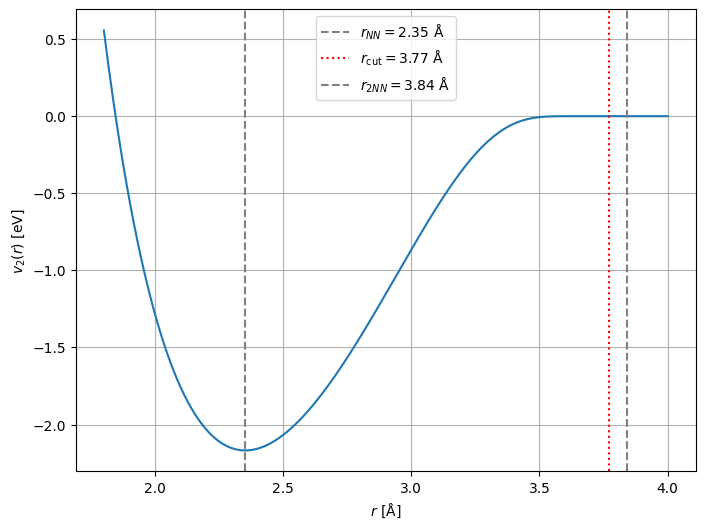

In [23]:
# Define symbolic variable
r = sp.Symbol('r', real=True, positive=True)

# Parameters from the SW potential
A_val = 7.049556277
B_val = 0.6022245584
p_val = 4
q_val = 0
a_val = 1.8 

sigma = 2.0951  # Angstroms
epsilon = 2.1682  # eV
A, B, p, q, a = 7.049556277, 0.6022245584, 4, 0, 1.8

# Define v2(r) in real units as a function
def v2_real_func(r):
    r_red = r / sigma
    if r >= a * sigma:
        return 0.0
    return epsilon * A * (B * r_red**(-p) - r_red**(-q)) * np.exp(1 / (r_red - a))

plt.figure(figsize=(8,6))

r_vals_real = np.linspace(1.8, 4, 500)
v2_vals = [v2_real_func(r) for r in r_vals_real]


plt.plot(r_vals_real, v2_vals, color='tab:blue')
plt.axvline(x=2.35, color='gray', linestyle='--', label=r'$r_{NN} = 2.35\ \mathrm{\AA}$')
plt.axvline(x=a * sigma, color='red', linestyle=':', label=fr'$r_{{\mathrm{{cut}}}} = {a * sigma:.2f}\ \mathrm{{\AA}}$')
plt.axvline(x=3.84, color='gray', linestyle='--', label=r'$r_{2NN} = 3.84\ \mathrm{\AA}$')
plt.xlabel(r'$r\ \mathrm{[\AA]}$')
plt.ylabel(r'$v_2(r)\ \mathrm{[eV]}$')

plt.grid(True)
plt.legend();


# b) Force

Given the shape of the 2-body term of the Stillinger Weber potential, draw a sketch of how $F(r)$ looks like. What is the relationship between force and potential?

## Force calculation
We compute the gradient of the potential to find the force between atoms $i$ and $j$

$$
\begin{align*}
- \nabla_{\mathbf{r}_i} v_2(r_{ij}) 
&= - \frac{\partial}{\partial \mathbf{r}_i} \left\{ \epsilon A \left( B r_{ij}^{-p} - r_{ij}^{-q} \right) \exp \left[ \left( r_{ij} - a \right)^{-1} \right] \right\} \\
&= - \epsilon A \frac{\mathbf{r}_{ij}}{r_{ij}} \left( \left[ \frac{\partial}{\partial r} \left( B r^{-p} - r^{-q} \right) \right] \bigg|_{r_{ij}} \exp \left[ \left( r_{ij} - a \right)^{-1} \right] \right. \\
&\quad + \left. \left( B r_{ij}^{-p} - r_{ij}^{-q} \right) \left\{ \frac{\partial}{\partial r} \exp \left[ (r - a)^{-1} \right] \right\} \bigg|_{r_{ij}} \right) \\
&= - \epsilon A \frac{\mathbf{r}_{ij}}{r_{ij}} \left\{ \left( -p B r_{ij}^{-p-1} + q r_{ij}^{-q-1} \right) \exp \left[ (r_{ij} - a)^{-1} \right] \right. \\
&\quad - \left. \left( B r_{ij}^{-p} - r_{ij}^{-q} \right) \exp \left[ (r_{ij} - a)^{-1} \right] (r_{ij} - a)^{-2} \right\} \\
&= v_2 \frac{\mathbf{r}_{ij}}{r_{ij}} \left[ \frac{p B r_{ij}^{-p-1} - q r_{ij}^{-q-1}}{B r_{ij}^{-p} - r_{ij}^{-q}} + (r_{ij} - a)^{-2} \right] \\
&\equiv \mathbf{f}_{ij}
\end{align*}
$$

If we impose the force to be zero, we find $r_{i,j}$ for which the potential is at a minimum, which equals to the next neighbour distance. We can solve this numerically with the following code:

In [24]:
# Define numerical derivative: force = -dv2/dr
def force_real_func(r, h=1e-6):
    return -(v2_real_func(r + h) - v2_real_func(r - h)) / (2 * h)

# Use minimize_scalar on |force| to find the root of the force
force_root_result = minimize_scalar(lambda r: abs(force_real_func(r)),
                                    bounds=(2.0, a * sigma - 1e-4),
                                    method='bounded')

print(force_root_result.x if force_root_result.success else None)

2.3516714010669038


We find:

$r_{NN} = 2.3517 \AA$

Which fits with the experimental value of $2.35 \AA$. This means that the potentail has been fitted well and can reproduce this basic property for Silicon.

## b-facoltative) Plot the force
Use python and matplolib to plot the force as a function of the interatomic distance $r$. The force is computed by the function `force_real_func` in the cell above.

# c) Lattice constant 

Use the first neighbour distance to compute the lattice constant. Consider the crystal structure of Silicon.

# d) Compute energy per atom

Compute the energy per atom, still considering only first neighbours and neglecting the angular part.

## Behond first neighbors

In the **diamond cubic** structure, each atom has:

* **4 first-nearest neighbors**
* **12 second-nearest neighbors**
* **12 third-nearest neighbors**
* and so on...

But:

* The **cutoff** of the SW potential is $r_{\text{cut}} = 1.8\,\sigma = 3.7712\ \text{Å}$
* So only **1st and 2nd neighbor shells** may contribute.

Let’s check:

In the **diamond cubic structure**, the 2nd neighbors are:

* Distance:

  $$
  r_{\text{2nd}} = \frac{a}{\sqrt{2}} \approx \frac{5.43}{1.414} \approx 3.84\ \text{Å}
  $$
* Number:

  $$
  \text{12 second-nearest neighbors}
  $$

So:

* 1st NN: 4 neighbors at $r_1 = 2.3517$ Å $\implies$ included
* 2nd NN: 12 neighbors at $r_2 = \frac{a}{\sqrt{2}} \approx 3.84$ Å $\implies$ outside cutoff

## Include 2nd neighbors in the cutoff


$$
r_{\text{cut}} > r_{\text{2nd}} = 3.84\ \text{Å}
$$

That is, set a new $a' > \frac{r_{\text{2nd}}}{\sigma} = \frac{3.84}{2.0951} \approx 1.8$



### How does the curve change?

The pair potential $v_2(r)$ includes a **cutoff function** via the exponential:

$$
v_2(r) = \epsilon A \left( B r^{-p} - r^{-q} \right) \exp\left[\frac{1}{r/\sigma - a} \right]
\quad \text{for } r/\sigma < a
$$

* Increasing $a$ makes the **exponential decay slower**, thus:

  * **Flattens the tail**
  * Allows weak interactions from further neighbors (like 2nd shell)
* But also changes the **shape and curvature** of the potential well slightly

So the curve becomes:

* **Broader**
* **Less steep near the cutoff**
* With **nonzero tail** reaching 3.84 Å

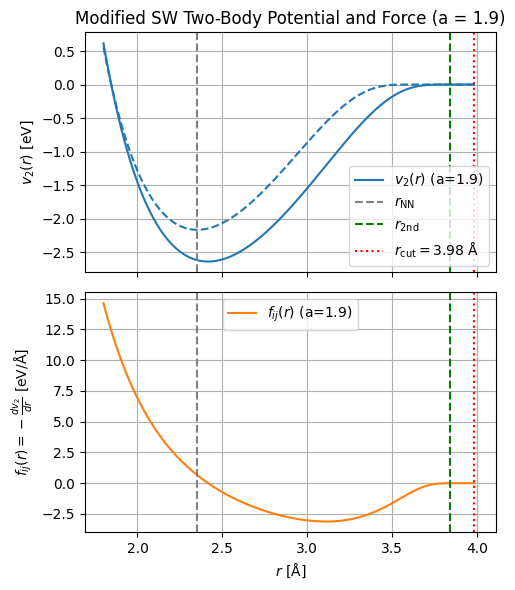

In [28]:
# Redefine constants
sigma = 2.0951  # Angstroms
epsilon = 2.1682  # eV
A = 7.049556277
B = 0.6022245584
p = 4
q = 0
a_modified = 1.9  # new cutoff value

# Define the potential function with modified cutoff
def v2_modified(r):
    r_red = r / sigma
    if r >= a_modified * sigma:
        return 0.0
    return epsilon * A * (B * r_red**(-p) - r_red**(-q)) * np.exp(1 / (r_red - a_modified))

# Define numerical derivative for force
def force_modified(r, h=1e-6):
    return -(v2_modified(r + h) - v2_modified(r - h)) / (2 * h)

# Prepare data for plotting
r_vals_mod = np.linspace(1.8, a_modified * sigma - 1e-4, 500)
v2_vals_mod = [v2_modified(r) for r in r_vals_mod]
force_vals_mod = [force_modified(r) for r in r_vals_mod]

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 6))

# Plot potential
ax1.plot(r_vals_real, v2_vals, '--')
ax1.plot(r_vals_mod, v2_vals_mod, color='tab:blue', label=r'$v_2(r)$ (a=1.9)')
ax1.axvline(x=2.3517, color='gray', linestyle='--', label=r'$r_{\mathrm{NN}}$')
ax1.axvline(x=3.84, color='green', linestyle='--', label=r'$r_{\mathrm{2nd}}$')
ax1.axvline(x=a_modified * sigma, color='red', linestyle=':', label=fr'$r_{{\mathrm{{cut}}}} = {a_modified * sigma:.2f}\ \mathrm{{\AA}}$')
ax1.set_ylabel(r'$v_2(r)\ \mathrm{[eV]}$')
ax1.set_title('Modified SW Two-Body Potential and Force (a = 1.9)')
ax1.grid(True)
ax1.legend()

# Plot force
ax2.plot(r_vals_mod, force_vals_mod, color='tab:orange', label=r'$f_{ij}(r)$ (a=1.9)')
ax2.axvline(x=2.3517, color='gray', linestyle='--')
ax2.axvline(x=3.84, color='green', linestyle='--')
ax2.axvline(x=a_modified * sigma, color='red', linestyle=':')
ax2.set_xlabel(r'$r\ \mathrm{[\AA]}$')
ax2.set_ylabel(r'$f_{ij}(r) = -\frac{dv_2}{dr}\ \mathrm{[eV/\AA]}$')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Energy per atom: 4 1st neighbors + 12 2nd neighbors
v2_1st = v2_modified(2.3517)
v2_2nd = v2_modified(3.84)
energy_per_atom_extended = 0.5 * (4 * v2_1st + 12 * v2_2nd)
#print(energy_per_atom_extended)